In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Object masks from prompts with SAM

The Segment Anything Model (SAM) predicts object masks given prompts that indicate the desired object. The model first converts the image into an image embedding that allows high quality masks to be efficiently produced from a prompt. 

The `SamPredictor` class provides an easy interface to the model for prompting the model. It allows the user to first set an image using the `set_image` method, which calculates the necessary image embeddings. Then, prompts can be provided via the `predict` method to efficiently predict masks from those prompts. The model can take as input both point and box prompts, as well as masks from the previous iteration of prediction.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [3]:
using_colab = False

In [4]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/truck.jpg
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/groceries.jpg
        
    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up

Necessary imports and helper functions for displaying points, boxes, and masks.

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import os
import shutil
from PIL import Image

In [6]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.random.uniform(low=0.3, high=1.0, size=3)
        color= color / np.max(color)
        color = np.concatenate([color, np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [7]:
class Maskdata:
    def __init__(self, mask, score, idx):
        self.mask = mask
        self.score = score
        self.idx = idx

In [8]:
def nms(masks_list, conf_threshold = 0.8, lap_threshold=0.7):
    # filter masks based on confidence threshold and overlap
    mask_list_thresholded= []
    mask_list_new = []
    masks_sorted = sorted(masks_list, key=lambda x: x.score, reverse=True)

    for mask_data in masks_sorted:
        if mask_data.score > conf_threshold:
            mask_list_thresholded.append(mask_data)
        else:
            pass
    
    while len(mask_list_thresholded) > 0:
        current_mask = mask_list_thresholded[0]
        mask_list_thresholded = mask_list_thresholded[1:]
        mask_list_new.append(current_mask)

        mask_list_thresholded = [
        mask_data for mask_data in mask_list_thresholded
        if calculate_overlap(current_mask.mask, mask_data.mask) <= lap_threshold
        ]
        
    print("mask_list_new:", len(mask_list_new))
    return mask_list_new

def calculate_overlap(mask, masks):
    # Calculate overlap between two masks
    overlap_pixels = (mask & masks).sum()
    total_pixels = min(mask.sum(), masks.sum())
    overlap = overlap_pixels / total_pixels
    return overlap


## Example image

In [9]:
image = cv2.imread('images/strawberry1.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

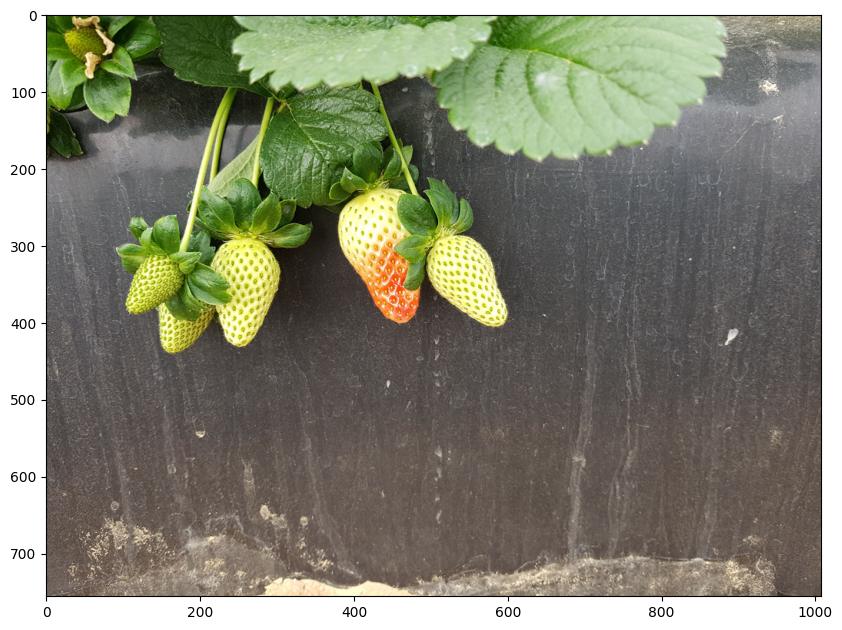

In [10]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

## Selecting objects with SAM

First, load the SAM model and predictor. Change the path below to point to the SAM checkpoint. Running on CUDA and using the default model are recommended for best results.

In [11]:
sam_checkpoint = "sam_vit_h_4b8939.pth"
device = "cuda"
model_type = "vit_h"

In [12]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/rcli/anaconda3/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Process the image to produce an image embedding by calling `SamPredictor.set_image`. `SamPredictor` remembers this embedding and will use it for subsequent mask prediction.

In [13]:
predictor.set_image(image)

In order to perform a global prompt, we set a certain spacing and uniformly generate sampling points that cover the entire image

In [14]:
output_folder = "/home/rcli/sam-ws/segment-anything/brl_notebooks/universal_masks"
save_folder = "/home/rcli/sam-ws/segment-anything/brl_notebooks/isolating_masks"

image_height = image.shape[0]
image_width = image.shape[1]
image_size = image_height * image_width
grid_size = 21 # prompt点间距

x_points = np.arange(21,image_width,grid_size)
y_points = np.arange(21,image_height,grid_size)

grid_points = [(x, y) for x in x_points for y in y_points]


We attempt to classify and retain masks, and perform NMS operations on masks within the same level

mask_list_new: 52


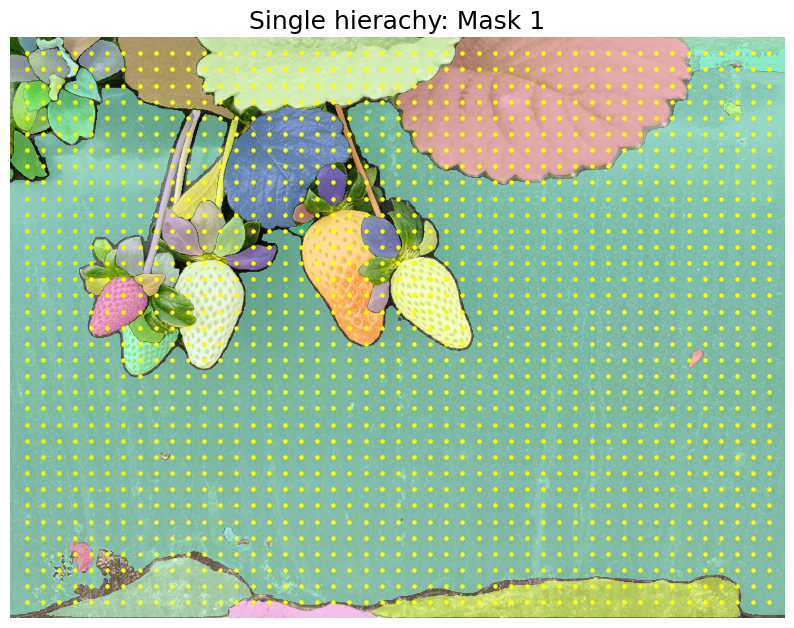

mask_list_new: 20


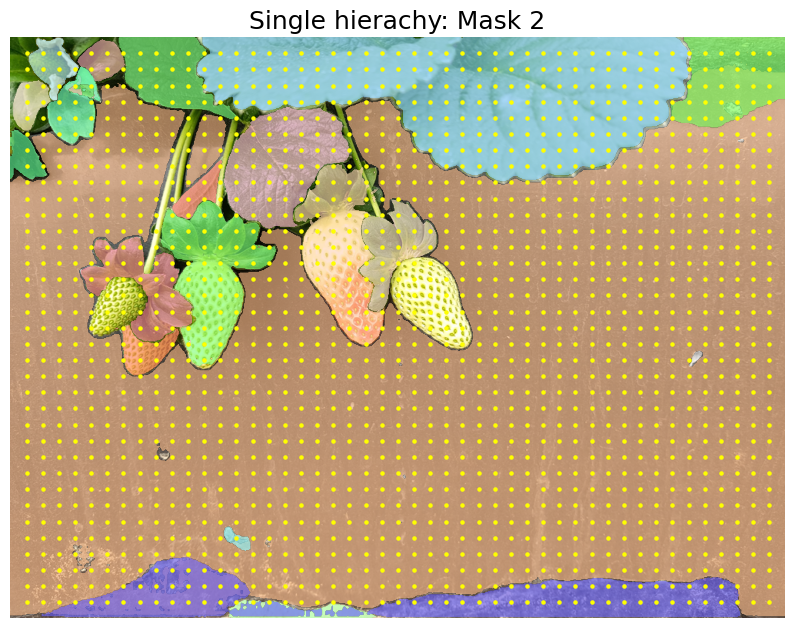

mask_list_new: 8


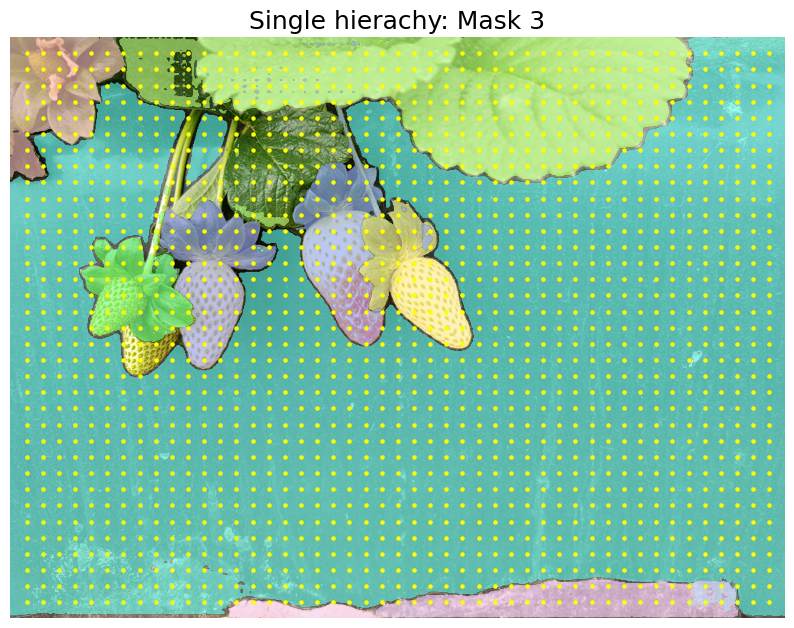

In [15]:
for j in range(3):
    masks_list = []
    index = 1
    for i in range(len(grid_points)):
        input_point = np.array([grid_points[i]])
        input_label = np.array([1])
        masks, scores, logits = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,  # change here
        )

        mask = masks[j]
        score = scores[j]
        mask_data = Maskdata(mask, score, index)
        masks_list.append(mask_data)
        index += 1

    sam_mask_list = nms(masks_list, conf_threshold=0.88, lap_threshold=0.7)
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(image)

    x_coords, y_coords = zip(*grid_points)
    ax.scatter(x_coords, y_coords, color='yellow', marker='.', s=20)

    for mask_data in sam_mask_list:
        show_mask(mask_data.mask, plt.gca(), random_color=True)
    plt.title(f"Single hierachy: Mask {j+1}", fontsize=18)
    plt.axis('off')
    plt.show() 